In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/guided_grounded_instructpix2pix/'

/content/drive/MyDrive/guided_grounded_instructpix2pix


In [3]:
!python -m pip install -e GroundingDINO

Obtaining file:///content/drive/MyDrive/guided_grounded_instructpix2pix/GroundingDINO
  Preparing metadata (setup.py) ... done
  Running setup.py develop for groundingdino


In [4]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 26.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
!pip install diffusers transformers accelerate scipy safetensors

In [6]:
!pip install segment-anything

In [7]:
!pip install torchmetrics

In [8]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qf9z01hx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qf9z01hx
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [13]:
!pip install transformers torch peft tqdm numpy scikit-learn

In [10]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [12]:
!cd GroundingDINO

In [14]:
import math
import torch
import os
from PIL import Image
from pathlib import Path

from tqdm.notebook import tqdm
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

from diffusers import DDIMScheduler, DDIMInverseScheduler
from pipeline_stable_diffusion_grounded_instruct_pix2pix import StableDiffusionInstructPix2PixPipeline

from external_mask_extractor_improved import ExternalMaskExtractor
from transformers import logging
logging.set_verbosity_error()

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [15]:
def load_pil_image(image_path, resolution=512):
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    factor = resolution / max(width, height)
    factor = math.ceil(min(width, height) * factor / 64) * 64 / min(width, height)
    width = int((width * factor) // 64) * 64
    height = int((height * factor) // 64) * 64
    image = ImageOps.fit(image, (width, height), method=Image.Resampling.LANCZOS)
    return image

In [16]:
device = 'cuda:0'

# pipeline
num_timesteps = 100
pipeline = StableDiffusionInstructPix2PixPipeline.from_pretrained("timbrooks/instruct-pix2pix",
                                                                  torch_dtype=torch.float16,
                                                                  safety_checker=None).to(device)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config, set_alpha_to_zero=False)

pipeline.scheduler.set_timesteps(num_timesteps)
pipeline.inverse_scheduler.set_timesteps(num_timesteps)

Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The config attributes {'algorithm_type': 'dpmsolver++', 'dynamic_thresholding_ratio': 0.995, 'lower_order_final': True, 'sample_max_value': 1.0, 'skip_prk_steps': True, 'solver_order': 2, 'solver_type': 'midpoint', 'thresholding': False} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [17]:
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# extractor = ExternalMaskExtractor(device=device)

# Define model paths here
SAM_PATH = '/content/drive/MyDrive/SAM/sam_vit_h_4b8939.pth'
TARGET_PREDICTOR_PATH = "/content/drive/MyDrive/guided_grounded_instructpix2pix/models/target_finder_bert_lora_model"
SIZE_PREDICTOR_PATHS = ["/content/drive/MyDrive/guided_grounded_instructpix2pix/models/size_predictor_models/standardSmoothL1_model.pth",
                        "/content/drive/MyDrive/guided_grounded_instructpix2pix/models/size_predictor_models/CombLoss_model.pth"]

device = 'cuda:0'
extractor = ExternalMaskExtractor(
    device=device,
    target_predictor_model_path=TARGET_PREDICTOR_PATH,
    size_predictor_model_path=SIZE_PREDICTOR_PATHS,
    sam_path=SAM_PATH
)

def inference(pipeline, image_pil, instruction, image_guidance_scale, text_guidance_scale, seed, blending_range):
    final_mask, first_target_phrase, second_target_phrase, directional_phrase, final_sentence, predicted_size_mask = extractor.get_external_mask(image_pil, instruction, verbose=True)

    inv_results = pipeline.invert(final_sentence, image_pil, num_inference_steps=num_timesteps, inv_range=blending_range)
    generator = torch.Generator(device).manual_seed(seed) if seed is not None else torch.Generator(device)
    edited_image = pipeline(final_sentence, src_mask=final_mask, image=image_pil,
                            guidance_scale=text_guidance_scale, image_guidance_scale=image_guidance_scale,
                            num_inference_steps=num_timesteps, generator=generator).images[0]
    return edited_image, final_mask, predicted_size_mask

Loading CLIP model...
Loading size prediction models...
  > Loading model from: /content/drive/MyDrive/guided_grounded_instructpix2pix/models/size_predictor_models/standardSmoothL1_model.pth
  > Loading model from: /content/drive/MyDrive/guided_grounded_instructpix2pix/models/size_predictor_models/CombLoss_model.pth
All models loaded successfully.


final text_encoder_type: bert-base-uncased


In [18]:
verbose = False

def edit_image(
    pipeline,
    image_path,
    edit_instruction,
    image_guidance_scale=1.5,
    guidance_scale=7.5,
    seed=42,
    start_blending_at_tstep=1000,
    end_blending_at_tstep=1,
    verbose=False
):
    blending_range = [start_blending_at_tstep, end_blending_at_tstep]

    image = load_pil_image(image_path)

    edited_image, final_mask, predicted_size_mask = inference(
        pipeline, image, edit_instruction,
        image_guidance_scale=image_guidance_scale,
        text_guidance_scale=guidance_scale,
        seed=seed,
        blending_range=blending_range
    )

##############################################################
    # Extract original image filename without extension
    original_filename = Path(image_path).stem

    # Define output directories
    edited_dir = Path('/content/drive/MyDrive/guided_grounded_instructpix2pix/ggip2p_edited_images')
    mask_dir = Path('/content/drive/MyDrive/guided_grounded_instructpix2pix/ggip2p_edited_masks')

    # Create directories if they don't exist
    edited_dir.mkdir(parents=True, exist_ok=True)
    mask_dir.mkdir(parents=True, exist_ok=True)

    # Save edited image
    edited_image_path = edited_dir / f'{original_filename}.jpg'
    edited_image.save(edited_image_path)

    # Convert masks to PIL Images if needed
    if not isinstance(final_mask, Image.Image):
        final_mask = Image.fromarray(final_mask.astype('uint8'))
    if not isinstance(predicted_size_mask, Image.Image):
        predicted_size_mask = Image.fromarray((predicted_size_mask.cpu().numpy() * 255).astype('uint8'))

    # Save masks
    final_mask_path = mask_dir / f'{original_filename}_final_mask.png'
    predicted_size_mask_path = mask_dir / f'{original_filename}_size_mask.png'

    final_mask.save(final_mask_path)
    predicted_size_mask.save(predicted_size_mask_path)

##############################################################

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(edited_image)
    axes[1].set_title('Edited Image')
    axes[1].axis('off')

    axes[2].imshow(final_mask)
    axes[2].set_title('Final Mask')
    axes[2].axis('off')

    axes[3].imshow(predicted_size_mask, cmap='gray')
    axes[3].set_title('Predicted Size Mask')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

Prompt convert the stone on the left of the bird to autumn leaves
First Target: bird
First Target Phrase: the bird
Second Target: stone
Second Target Phrase: the stone
Directional Word: left
Directional Phrase: on the left of
Final Sentence: convert the stone to autumn leaves
Matched direction: left
Direction_is_used:  False


Shape of Boxes for the bird  :  torch.Size([1, 4])
Shape of Boxes for bird  (without the) :  torch.Size([1, 4])
ALL Boxes xyxy1 Shape:  torch.Size([2, 4])
bird  is_singular? -->  True
Filtered Boxes1 Shape:  torch.Size([1, 4])
boxes_xyxy1:  tensor([[277.0327,  85.9610, 327.6649, 161.3558]])
Shape of Boxes for the stone  :  torch.Size([1, 4])
Shape of Boxes for stone  (without the) :  torch.Size([10, 4])
ALL Boxes xyxy1 Shape:  torch.Size([11, 4])
stone  is_singular? -->  True
Filtered Boxes2 Shape:  torch.Size([9, 4])
Direction_is_used?  False
Apply_relative_directional_logic left
Directed Filtered Boxes2 Shape:  torch.Size([1, 4]) Direction_is_used?  True
boxes_xyxy2:  tensor([[150.4469, 117.1914, 280.7531, 151.7698]])


  0%|          | 0/100 [00:00<?, ?it/s]

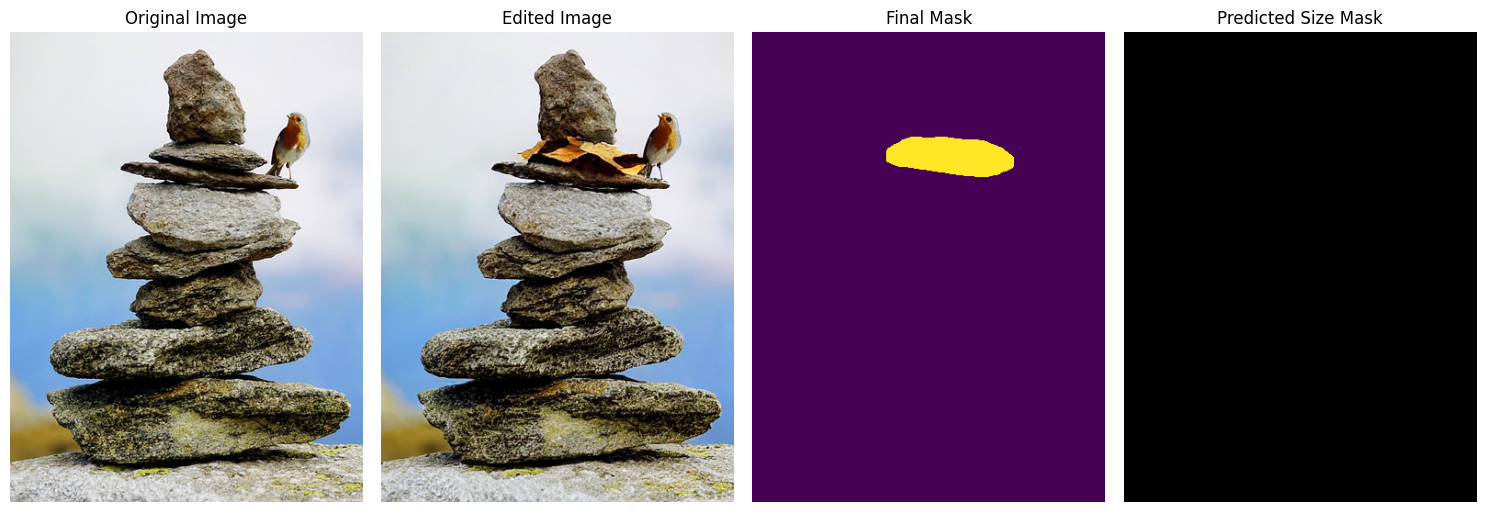

In [19]:
edit_image(
    pipeline=pipeline,
    image_path = "/content/drive/MyDrive/guided_grounded_instructpix2pix/some_test_image/cairn-2806850_640-pixabay.jpg",
    edit_instruction = "convert the stone on the left of the bird to autumn leaves",
    image_guidance_scale=1.5,
    guidance_scale=7.5,
    seed=42,
    start_blending_at_tstep = 100
)

Prompt Convert the left buildings into cottages
First Target: buildings
First Target Phrase: the left buildings
Second Target: No second target found
Second Target Phrase: 
Directional Word: left
Directional Phrase: the left
Final Sentence: Convert into cottages
Matched direction: left
Direction_is_used:  False


Shape of Boxes for the left buildings  :  torch.Size([2, 4])
Shape of Boxes for left buildings  (without the) :  torch.Size([1, 4])
ALL Boxes xyxy1 Shape:  torch.Size([3, 4])
buildings  is_singular? -->  False
Filtered Boxes1 Shape:  torch.Size([2, 4])
apply_directional_logic left
Directed Filtered Boxes1 Shape:  torch.Size([1, 4]) Direction_is_used?  True
Direction word found in first_target_phrase. direction_is_used = True
boxes_xyxy1:  tensor([[ 37.8978, 316.3321, 156.8180, 459.7641]])
Not using size predictor - no direction or direction already used.


  0%|          | 0/100 [00:00<?, ?it/s]

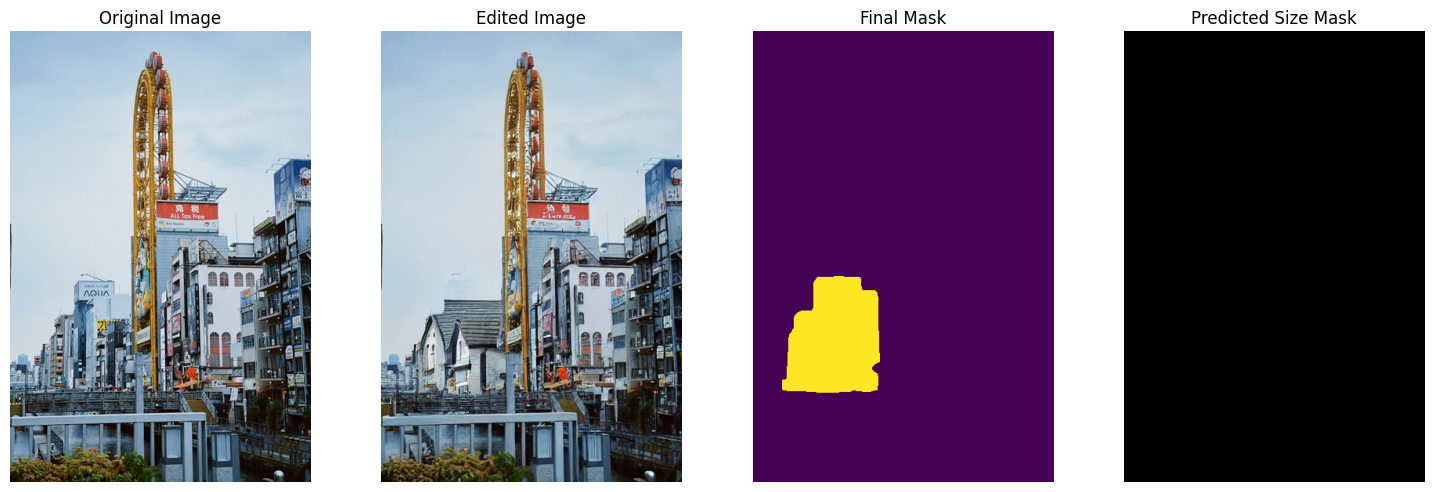

In [20]:
edit_image(
    pipeline=pipeline,
    image_path = '/content/drive/MyDrive/guided_grounded_instructpix2pix/some_test_image/harrison-lin-y2BUSMogBUU-unsplash.jpg',
    edit_instruction = 'Convert the left buildings into cottages',
    image_guidance_scale=1.5,
    guidance_scale=7.5,
    seed=42,
    start_blending_at_tstep = 100
)

Prompt convert the bottom branch to a flowering branch
First Target: branch
First Target Phrase: the bottom branch
Second Target: No second target found
Second Target Phrase: 
Directional Word: bottom
Directional Phrase: the bottom
Final Sentence: convert to a flowering branch
Matched direction: bottom
Direction_is_used:  False


Shape of Boxes for the bottom branch  :  torch.Size([2, 4])
Shape of Boxes for bottom branch  (without the) :  torch.Size([3, 4])
ALL Boxes xyxy1 Shape:  torch.Size([5, 4])
branch  is_singular? -->  True
Filtered Boxes1 Shape:  torch.Size([2, 4])
apply_directional_logic bottom
Directed Filtered Boxes1 Shape:  torch.Size([1, 4]) Direction_is_used?  True
Direction word found in first_target_phrase. direction_is_used = True
boxes_xyxy1:  tensor([[128.6967, 358.2551, 384.0308, 430.4597]])
Not using size predictor - no direction or direction already used.


  0%|          | 0/100 [00:00<?, ?it/s]

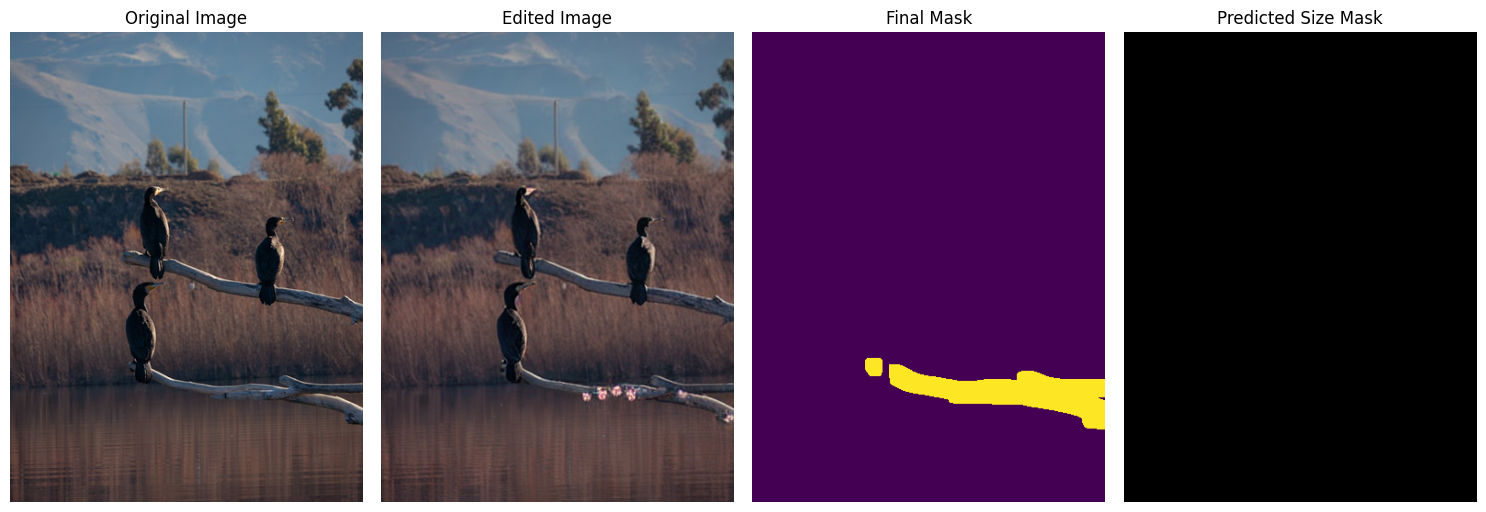

In [21]:
edit_image(
    pipeline=pipeline,
    image_path = '/content/drive/MyDrive/guided_grounded_instructpix2pix/some_test_image/katelyn-greer-lFgmWqxMVjs-unsplash_branch.jpg',
    edit_instruction = 'convert the bottom branch to a flowering branch',
    image_guidance_scale=1.5,
    guidance_scale=7.5,
    seed=42,
    start_blending_at_tstep = 1000
)

Prompt make the horse on the left side of gray horse to a white horse
First Target: horse
First Target Phrase: gray horse
Second Target: horse
Second Target Phrase: the horse
Directional Word: left
Directional Phrase: on the left side of
Final Sentence: make the horse to a white horse
Matched direction: left
Direction_is_used:  False


Shape of Boxes for gray horse  :  torch.Size([1, 4])
ALL Boxes xyxy1 Shape:  torch.Size([1, 4])
horse  is_singular? -->  True
boxes_xyxy1:  tensor([[291.5685,  62.4680, 401.0441, 383.8920]])
Shape of Boxes for the horse  :  torch.Size([3, 4])
Shape of Boxes for horse  (without the) :  torch.Size([4, 4])
ALL Boxes xyxy1 Shape:  torch.Size([7, 4])
horse  is_singular? -->  True
Filtered Boxes2 Shape:  torch.Size([4, 4])
Direction_is_used?  False
Apply_relative_directional_logic left
Directed Filtered Boxes2 Shape:  torch.Size([1, 4]) Direction_is_used?  True
boxes_xyxy2:  tensor([[136.4570,  42.2834, 269.4107, 383.8110]])


  0%|          | 0/100 [00:00<?, ?it/s]

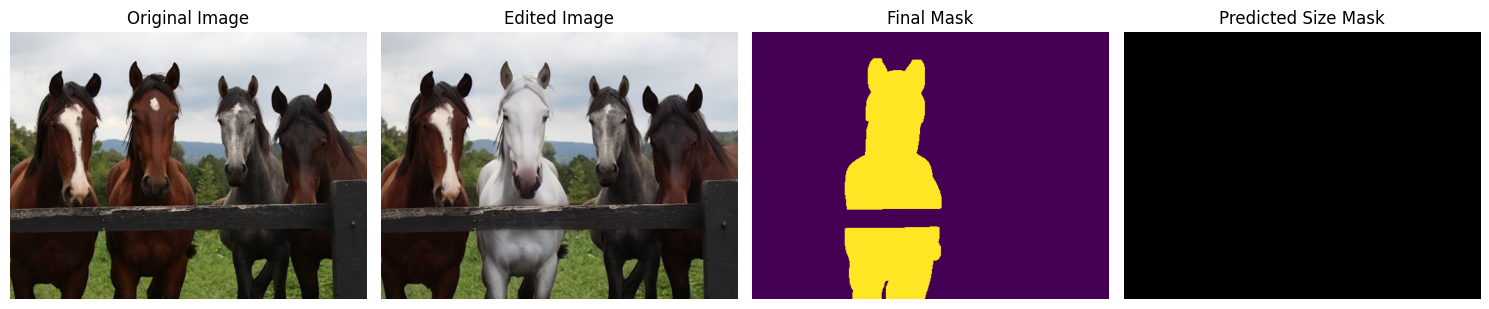

In [22]:
edit_image(
    pipeline=pipeline,
    image_path = '/content/drive/MyDrive/guided_grounded_instructpix2pix/some_test_image/lucia-macedo-xXLT52bAzkk-unsplash.jpg',
    edit_instruction = 'make the horse on the left side of gray horse to a white horse',
    image_guidance_scale=1.5,
    guidance_scale=7.5,
    seed=42,
    start_blending_at_tstep = 100
)

Prompt Turn the sprinkler into a potted plant
First Target: sprinkler
First Target Phrase: the sprinkler
Second Target: No second target found
Second Target Phrase: 
Directional Word: 
Directional Phrase: 
Final Sentence: Turn into a potted plant


Shape of Boxes for the sprinkler  :  torch.Size([1, 4])
Shape of Boxes for sprinkler  (without the) :  torch.Size([1, 4])
ALL Boxes xyxy1 Shape:  torch.Size([2, 4])
sprinkler  is_singular? -->  True
Filtered Boxes1 Shape:  torch.Size([1, 4])
boxes_xyxy1:  tensor([[247.4808, 171.0234, 461.6844, 315.7365]])
Not using size predictor - no direction or direction already used.


  0%|          | 0/100 [00:00<?, ?it/s]

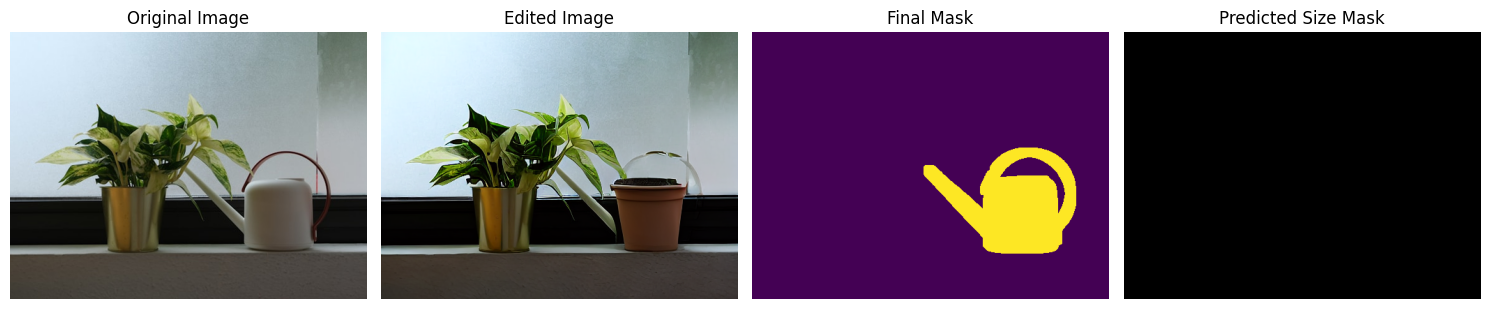

In [27]:
edit_image(
    pipeline=pipeline,
    image_path = "/content/drive/MyDrive/guided_grounded_instructpix2pix/some_test_image/simona-takareviciute-Y4g79V5-B3Q-unsplash.jpg",
    edit_instruction = 'Turn the sprinkler into a potted plant',
    image_guidance_scale=1.5,
    guidance_scale=7.5,
    seed=42,
    start_blending_at_tstep = 100
)

GroundingDINO Score("people"): 1.2335616946220398 from 3 boxes
GroundingDINO Score("animals"): 0.6873818337917328 from 2 boxes
GroundingDINO Score("them"): 0.42153725028038025 from 1 boxes
Replaced 'them' with 'people' (highest GroundingDINO score: 1.2335616946220398)
Prompt wear them red clothes
First Target: people
First Target Phrase: people
Second Target: No second target found
Second Target Phrase: 
Directional Word: 
Directional Phrase: 
Final Sentence: wear red clothes
Shape of Boxes for people  :  torch.Size([4, 4])
ALL Boxes xyxy1 Shape:  torch.Size([4, 4])
people  is_singular? -->  False
Filtered Boxes1 Shape:  torch.Size([3, 4])
boxes_xyxy1:  tensor([[364.1608, 204.7847, 430.3641, 309.8065],
        [100.5908, 254.6236, 159.6289, 331.9841],
        [200.3949, 167.1221, 271.0018, 333.3704]])
Not using size predictor - no direction or direction already used.


  0%|          | 0/100 [00:00<?, ?it/s]

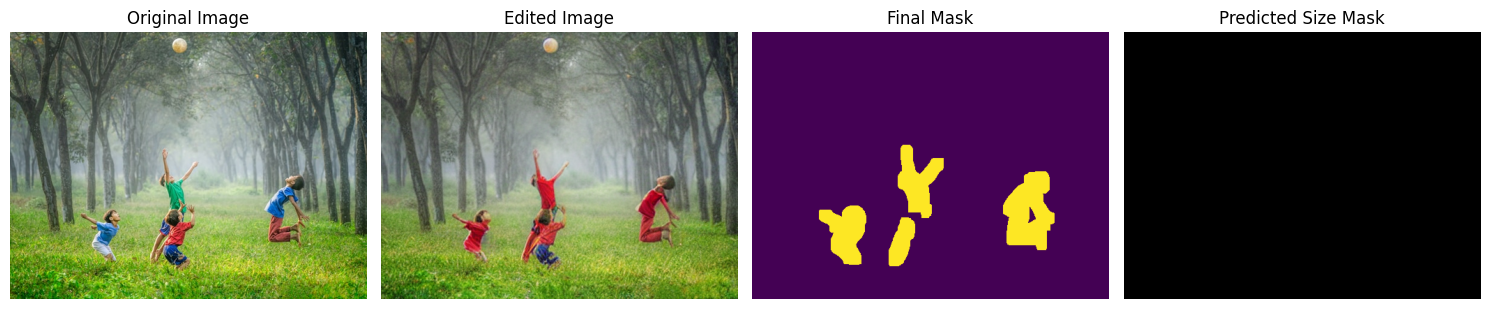

In [24]:
edit_image(
    pipeline=pipeline,
    image_path = '/content/drive/MyDrive/test_images/robert-collins-tvc5imO5pXk-unsplash.jpg',
    edit_instruction = 'wear them red clothes',
    image_guidance_scale=1.5,
    guidance_scale=7.5,
    seed=42,
    start_blending_at_tstep = 1000
)

Prompt put an orange on the top of the stones
First Target: stones
First Target Phrase: the stones
Second Target: No second target found
Second Target Phrase: 
Directional Word: top
Directional Phrase: on the top of
Final Sentence: put an orange
Matched direction: top
Direction_is_used:  False


Shape of Boxes for the stones  :  torch.Size([1, 4])
Shape of Boxes for stones  (without the) :  torch.Size([6, 4])
ALL Boxes xyxy1 Shape:  torch.Size([7, 4])
stones  is_singular? -->  False
Filtered Boxes1 Shape:  torch.Size([1, 4])
boxes_xyxy1:  tensor([[ 48.8658, 128.0404, 247.4387, 382.8468]])
Using size predictor with direction: top
remain noun phrase: orange
Predicted Ratio: [0.2030535  0.16716963]
Predicted Size in 512 (w, h): 50 50
Padding: (64, 64, 0, 0)
Predicted Real Size (w, h): 50 50


  0%|          | 0/100 [00:00<?, ?it/s]

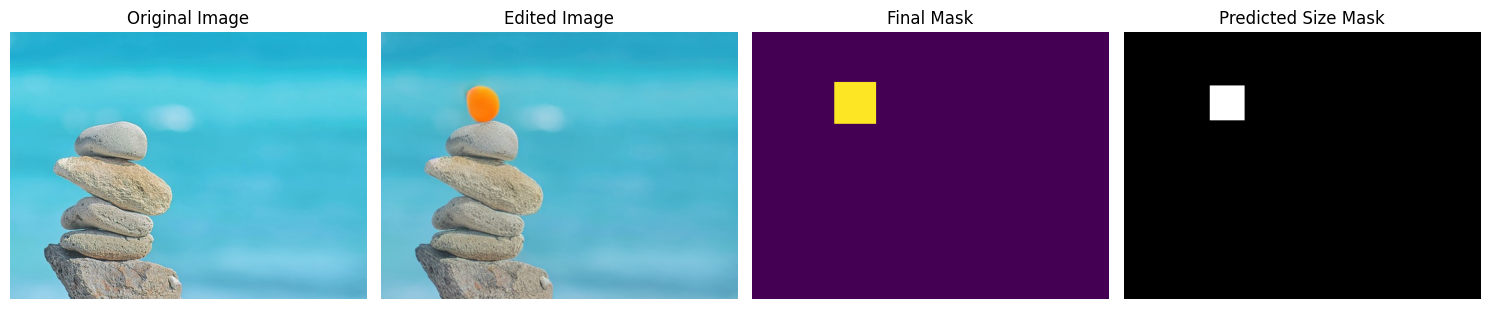

In [25]:
edit_image(
    pipeline=pipeline,
    image_path = '/content/drive/MyDrive/guided_grounded_instructpix2pix/some_test_image/cairn-7428729_64-pixabay.jpg',
    edit_instruction = 'put an orange on the top of the stones',
    image_guidance_scale=1.5,
    guidance_scale=7.5,
    seed=42,
    start_blending_at_tstep = 1000
)

Prompt add a beautiful butterfly on the top of the candle
First Target: candle
First Target Phrase: the candle
Second Target: No second target found
Second Target Phrase: 
Directional Word: top
Directional Phrase: on the top of
Final Sentence: add a beautiful butterfly
Matched direction: top
Direction_is_used:  False


Shape of Boxes for the candle  :  torch.Size([2, 4])
Shape of Boxes for candle  (without the) :  torch.Size([1, 4])
ALL Boxes xyxy1 Shape:  torch.Size([3, 4])
candle  is_singular? -->  True
Filtered Boxes1 Shape:  torch.Size([1, 4])
boxes_xyxy1:  tensor([[196.6803, 215.3564, 206.9166, 281.7443]])
Using size predictor with direction: top
remain noun phrase: beautiful butterfly
Predicted Ratio: [8.158843  1.1079975]
Predicted Size in 512 (w, h): 83 74
Padding: (0, 0, 64, 64)
Predicted Real Size (w, h): 83 74


  0%|          | 0/100 [00:00<?, ?it/s]

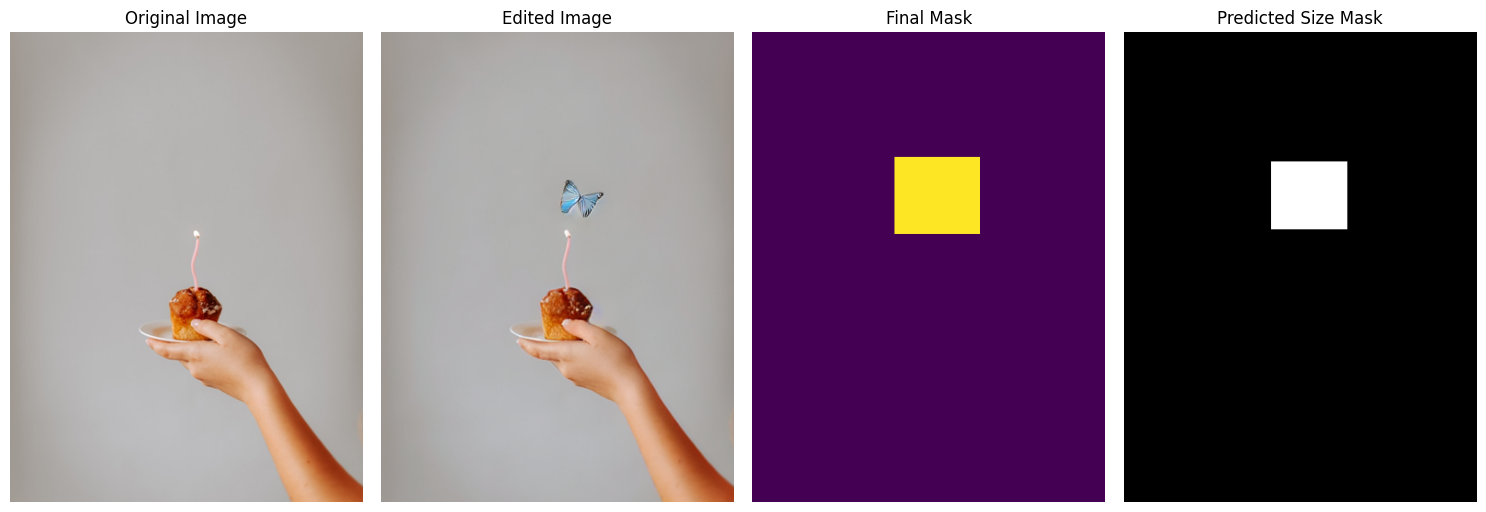

In [26]:
edit_image(
    pipeline=pipeline,
    image_path = "/content/drive/MyDrive/test_images/kateryna-hliznitsova-zKvV5yxVHfI-unsplash_big.jpg",
    edit_instruction = "add a beautiful butterfly on the top of the candle",
    image_guidance_scale=1.5,
    guidance_scale=7.5,
    seed=42,
    start_blending_at_tstep = 1000
)